# Introduction and dataset description
The dataset is called sign-language MNIST (Modified National Institute of Standards and Technology database). It is similar to MNIST dataset of handwritten digits because each image also contains 784 (28*28) pixels with grayscale values between 0-255, but sign-language is more complex and harder to distinguish than digits. 

The sign language is based on American Sign Language (ASL) used by many North Americans who are deaf. There are 26 hand gestures representing each alphabetic letter A-Z, and are mapped to value (0-25) as labels in the dataset. However, due to gesture motions, these are no cases for 9=J and 25 = Z. Each observation is one character with 784 features representing each pixel and each value is the grayscale value 0-255. This is a ready-to-go dataset with no missing values. There are 27455 observations in the train set and 7172 observations in the test set.

This is a classification problem with 24 classes of letters and 784 features. Because the values are derived from images, the methods are also image-based and the problem is related to computer vision.



In [ ]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.7 MB/s 
     |████████████████████████████████| 1.1 MB 32.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=21e8480755c24e0aa0bb300db76acd190eab38adbe18a70943ac062222a08b80
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=f2bfd12ba64e1e20a75c6c927638c6bebdecad591f5e93cc6784d7aacbde4d7e
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [ ]:
import pandas as pd
import numpy as np
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.manifold import TSNE
import seaborn as sns
import umap

# Loading the dataset

In [ ]:
train = pd.read_csv('sign_mnist_train.csv')
test = pd.read_csv('sign_mnist_test.csv')

# EDA

The following plot shows that the data seems balanced for each label. Most labels have more than 1000 observations to support and it should be enough to train a machine learning model.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


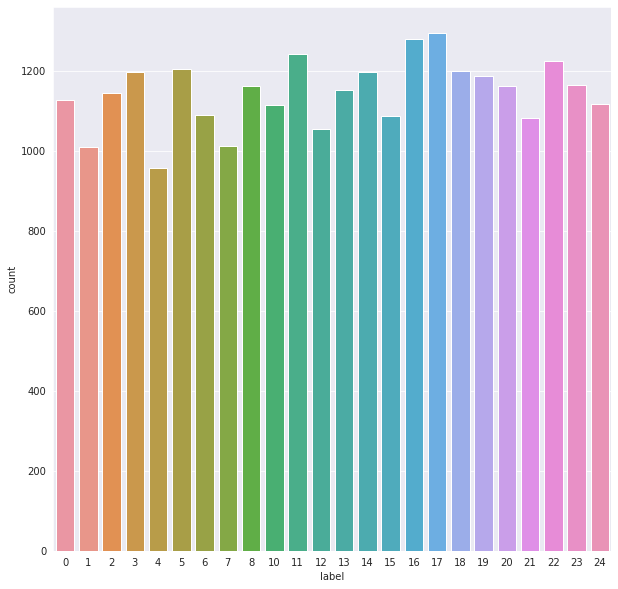

In [ ]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train['label'])

In [ ]:
train.shape

(27455, 785)

In [ ]:
test.shape

(7172, 785)

In [ ]:
y_train = train['label']
y_test = test['label']
del train['label']
del test['label']

A taste of the data in training set (excluding labels).

In [ ]:
train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
x_train = train.values
x_test = test.values

# Model 1: PCA + t-SNE + random forest


1.   Pre-processing the data using PCA + t-SNE
2.   Reasons for choosing random forest instead of other models




In [ ]:
X = pd.concat([train,test])
y = pd.concat([y_train,y_test])

## Pre-processing the data using PCA + t-SNE
I came across the technique t-SNE as another dimension reduction method in addition to PCA. The model performance using PCA or t-SNE only is not good. But when I combine these two methods, the 24 labels can be separated into clusters by only two principal components, as shown in the diagram below. Before performing the dimension reduction, random forest can only achieve 80% accuracy on the test set with 784 predictors. By combining PCA and t-SNE, random forest can achieve 94% accuracy with only 2 predictors.

PCA is a technique to map data into principal components that could best explain the variance of the data. t-SNE can transfer high-dimensional data by modeling each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. Finally t-SNE will generate two or three dimensions for visualization purpose.

To keep most of the variance, I choose the first 200 principal components from PCA and then use this first 200 principal components for t-SNE analysis.

In [ ]:
only_pca_model = decomposition.PCA(random_state=0)
only_pca_model.n_components = 200
only_pca_data = only_pca_model.fit_transform(X/255)
only_pca_data = np.vstack((only_pca_data.T, y)).T
model = TSNE(n_components =2, random_state =0, perplexity =50, n_iter=1000)
pca_tsne_data = model.fit_transform(only_pca_data)

pca_tsne_data = np.vstack((pca_tsne_data.T, y)).T
pca_tsne_df = pd.DataFrame(pca_tsne_data, columns = ('PC 1', 'PC 2', 'label'))
pca_tsne_df.head()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,PC 1,PC 2,label
0,4.183319,23.638281,3.0
1,41.277313,50.769257,6.0
2,76.771126,1.460401,2.0
3,70.576401,-25.370625,2.0
4,-26.183758,-45.619373,13.0


In [ ]:
pca_tsne_data.shape

(34627, 3)

Here is the plot after PCA and t-SNE transformation. The 24 clusters are separated well visually by only two dimensions.

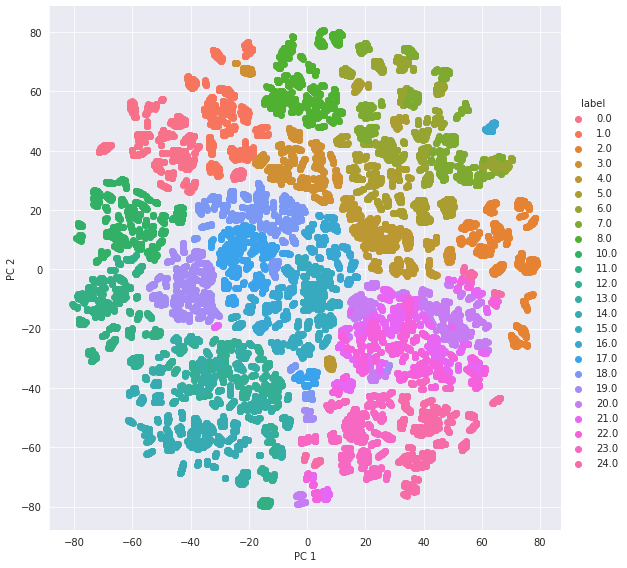

In [ ]:
sns.FacetGrid(pca_tsne_df, hue='label', height=8).map(plt.scatter, 'PC 1', "PC 2").add_legend()

In [ ]:
y_train = pca_tsne_data[0:27455,2]
y_test = pca_tsne_data[27455:,2]
x_train = pca_tsne_data[0:27455,0:2]
x_test = pca_tsne_data[27455:,0:2]

In [ ]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

## Reasons for choosing random forest instead of other models
After transformation, the data contains only two features. The intention of the model should be to separate the 24 clusters into blocks using smooth curves, based on the above plot. Some natural ideas would be SVM, decision tree and random forest. 

Considering SVM, for this multi-classification problem, SVM would be more complex because it's based on one-to-one classfication. If we build a one-to-one model for each class (class 1 vs. 2, class 1 vs. 3 and etc.), there will be 24*(23)/2 = 276 classifiers which makes it too complex. If we build a one-to-other model for each class (class 1 vs. all other classes, class 2 vs. all other classes and etc.), the dataset would be imbalanced because each class have roughly same number of observations in our study. Therefore, SVM is not a good choice.

I am curious about the performance of random forest given only two features. Random forest have two steps of randomization: randomly select a subset of training data, and randomly select a subset of features from all features. Because there are only two features, I guess that the random forest should have very similar performance compared with decision tree. Based on my simulation, decision tree can achieve an accuracy of around 92% and random forest can achieve an accuracy of around 93.7%. It seems that the ensemble method using bootstrap still outperforms the single decision tree. Therefore, my final decision is to use random forest to build the classification model.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(x_train,y_train)
predicted = model.predict(x_test)
model.score(x_test,y_test)

0.9415783602900167

From the classfication report, we can see that the predictions for class 21 (letter V) and class 22 (letter W) are not good.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test,predicted))  
print(classification_report(y_test,predicted))  

[[331   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 432   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 310   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 245   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 498   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 247   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 313  35   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0  62 374   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0  17   0   0 271   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 331   0   0   0   0   0   0   0   0
    0   0   0   0

In [ ]:
df = pd.DataFrame(y_test)

In [ ]:
y_test22_ind = df.index[df[0] == 22].tolist()

In [ ]:
incorrect = [59,6881,6913,6963]
predicted = model.predict(x_test)

In [ ]:
x_train = train.values
x_test = test.values

## Misclassified examples
Here are some misclassified examples for Class 22. Interestingly, they are misclassified to Class 21. Class 21 has two fingers up while Class 22 has three fingers up. The similarity between Class 21 and 22 make it difficult for only two featrues to distinguish them. However, if more information for each pixel is included in the model, the classification power should be better.

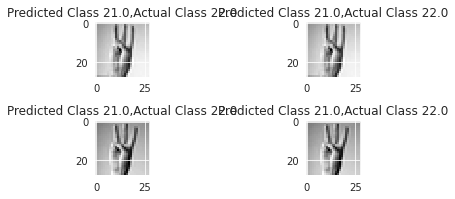

In [ ]:
i = 0
for c in incorrect[:4]:
    plt.subplot(2,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predicted[c], y_test[c]))
    plt.tight_layout()
    i += 1

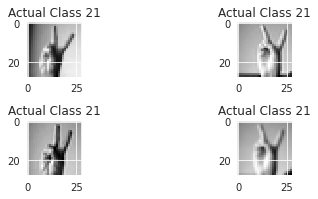

In [ ]:
y_test21_ind = df.index[df[0] == 21].tolist()
i = 0
for c in y_test21_ind[:4]:
    plt.subplot(2,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Actual Class 21")
    plt.tight_layout()
    i += 1

## Limitations
Although the combination of PCA and t-SNE can separate the clusters well, t-SNE can not be used as a pre-processing for training a supervised model. Because t-SNE is based on stochastic calculation, and there is no reference transformation similar to the eigenvectors in PCA. I combined test set and train set to get a full dataset for transformation. However, when a new dataset is arriving, there is no way to transform it in the same way as the data used to train the model.

I searched for other methods. A method called "UMAP" is said to be better than t-SNE and outperforms t-SNE in many aspects. UMAP has many methods to calculate the distance among points and can be used as a normal transformation like PCA, which has a standard way to transform new test data. However, based on my simulation, no method in UMAP can separate the dataset like t-SNE and the performance after transformation drops to 0.6 in accuracy. However, UMAP is good at separating clusters when the number of classes drops from 24 to around 10, and there could be used as a replacement of t-SNE. I will do more research on these dimension reduction methods and find a way to transform data like t-SNE in a non-stochastic way. 

# Model 2: Data Augmentation + Convolutional Nerual Network (CNN)

In [ ]:
x_train = train.values
x_test = test.values

In [ ]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
# Make the label to the form [1,0,0,0] if the outcome is in the first class out of four classes, used in CNN
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [ ]:
# transform the input to 3-dimension as required by CNN
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

## Data augmentation

There are some data augmentation techniques to make CNN more accurate and more generalized to accomodate changes in the picture.
 

1.   Randomly rotate some training images by 10 degrees. The degree of tilt of each person when doing the sign language can be different, the rotation can make the training set more generalized.
2.   
Randomly Zoom by 10% some training images. The size of picture is different, and most pictures have blank areas in the edge.

3. 
Randomly shift images horizontally by 10% of the width, randomly shift images vertically by 10% of the height. A typical trick used for classifying pictures. Used when the camera may not be centered.

In [ ]:
# Data augmentation to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

## Training a CNN

A Convolutional Neural Network uses a special mathematical matrix manipulation called the convolution operation to process data from the images and therefore is specially used to deal with pixel data and analyze images.

A convolutional neural network consists of an input layer, hidden layers and an output layer. The middle hidden layers does convolution by multiplying two matrices and yielding a third, smaller matrix. The convolutional layer will convolve the input and pass it to the next layer. Pooling layers reduce the dimensions. Fully connected layers map the representation between the input and the output (between layers). Dropout layers are utilised wherein a few neurons are dropped from the neural network during training process resulting in reduced size of the model to prevent overfitting. 

In [ ]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20
215/215 [==============================] - 126s 581ms/step - loss: 1.0822 - accuracy: 0.6593 - val_loss: 3.4884 - val_accuracy: 0.1174 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 115s 535ms/step - loss: 0.2204 - accuracy: 0.9289 - val_loss: 1.9084 - val_accuracy: 0.4862 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 119s 555ms/step - loss: 0.1065 - accuracy: 0.9667 - val_loss: 0.0856 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 147s 685ms/step - loss: 0.0680 - accuracy: 0.9781 - val_loss: 0.1028 - val_accuracy: 0.9697 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 132s 614ms/step - loss: 0.0493 - accuracy: 0.9843 - val_loss: 0.0086 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - 143s 665ms/step - loss: 0.0362 - accuracy: 0.9884 - val_loss: 0.0542 - val_accuracy: 0.9810 - lr: 0.0010
Epoch 7/20
215/215 [==========================

In [ ]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 7s 31ms/step - loss: 3.9630e-04 - accuracy: 0.9999
Accuracy of the model is -  99.98605847358704 %


## Model evaluation

From the plot, we can see that the accuracy is approaching 1 after 10 epochs. The learning rate of this model is pretty fast.

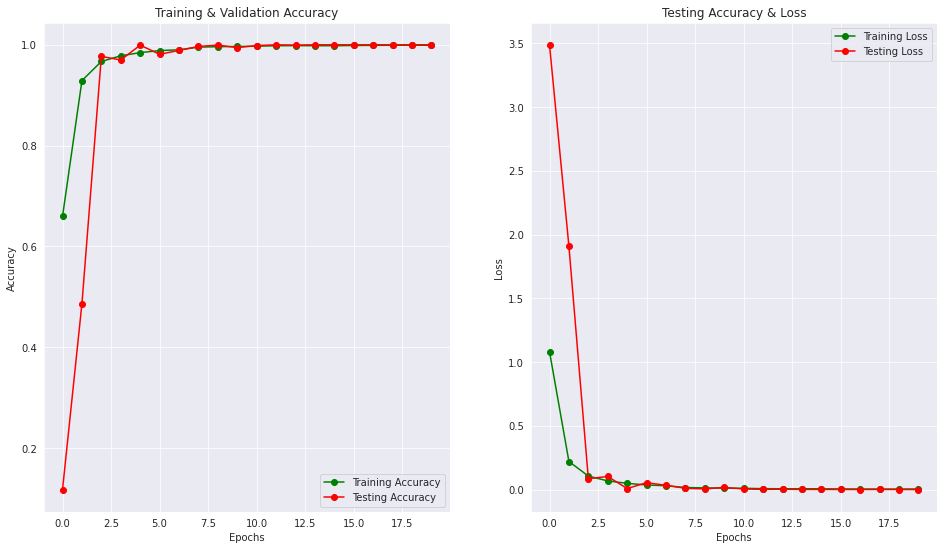

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


In [ ]:
predict_x = model.predict(x_test)
predictions=np.argmax(predict_x,axis=1)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1

225/225 [==============================] - 8s 37ms/step


In [ ]:
y_test=np.argmax(y_test,axis=1)
for i in range(len(y_test)):
    if(y_test[i] >= 9):
        y_test[i] += 1

Based on the confusion matrix, the precision and recall for all classes are 1. The model achieves an accuracy of 99.986% for the test set. 

In [ ]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y_test, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       1.00      1.00      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      1.00      1.00       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 18       1.00    

In [ ]:
cm = confusion_matrix(y_test,predictions)

In [ ]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

From the heatmap, we can see that only one figure of class 12 is misclassified into class 13.

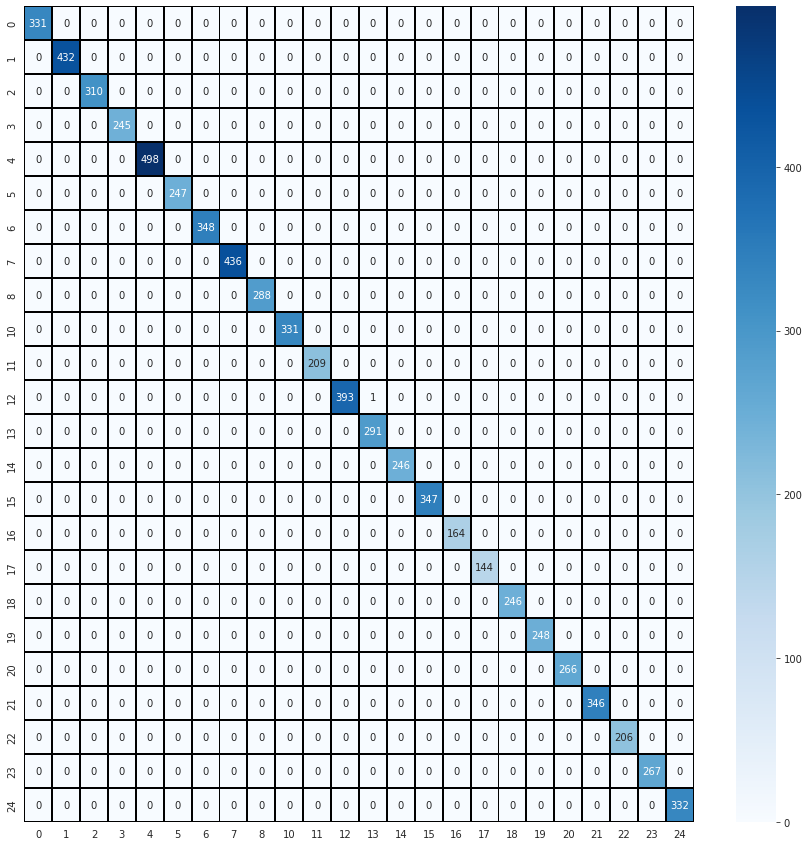

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
incorrect = np.nonzero(predictions != y_test)[0]

The misclassified figure is plotted below. The figure is blurry and it's nearly impossible to distinguish the position of thumb, Because the only difference of class 12 (letter m) and 13 (letter n) is the position of thumb, the error is due to the quality of data but not the model.

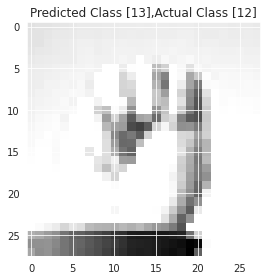

In [ ]:
plt.imshow(x_test[incorrect].reshape(28,28), cmap="gray", interpolation='none')
plt.title("Predicted Class {},Actual Class {}".format(predictions[incorrect], y_test[incorrect]))
plt.tight_layout()

# Conclusion

To predict the sign language based on images, I tried two famous method, random forest and CNN. 
Random forest without good pre-processing can only achieve an accuracy of 0.8. However, after PCA and t-SNE transformation, the accuracy is increased to 0.94.

CNN is designed for analyze images and performs well for this dataset. It achieves an accuracy of 0.999 after data augmentation. The only error made in the test set is due to the bad quality of that image. Therefore, CNN is a good choice for classifying sign language.

If I had more time, I would find a technique to replace t-SNE to make the model possible to be used in practice. For CNN, I would test the model performance in other datasets for American sign language.

References:

TECPERSON(2017), *Kaggle*, National Institute of Standards and Technology, accessed 29 Nov 2022, < https://www.kaggle.com/datasets/datamunge/sign-language-mnist >

MADHAV MATHUR(2019), *Kaggle*, accessed 29 Nov 2022, < https://www.kaggle.com/code/madz2000/cnn-using-keras-100-accuracy/notebook >